In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
assert not ((int(torch.__version__.split('.')[0]) == 1) and
            (int(torch.__version__.split('.')[1]) <  2)), """
  Prior to v1.2 PyTorch required a trick to plot a tensor.
  Either update or un-comment the next line with a \'monkey-patch\' by Jeremy Howard."""
# torch.Tensor.ndim = property(lambda x: len(x.shape))


Worining with Torch - Load Image

In [ ]:
image_path = "pics/two_angels.png"
im = torch.tensor(plt.imread(image_path, format='PNG')).float()
im/= 255 #Converting to range 0...1

im = im.sum(dim=2)/3  #sum RGB channels
im.shape

torch.Size([851, 1628])

: 

Original image


<function Tensor.type>

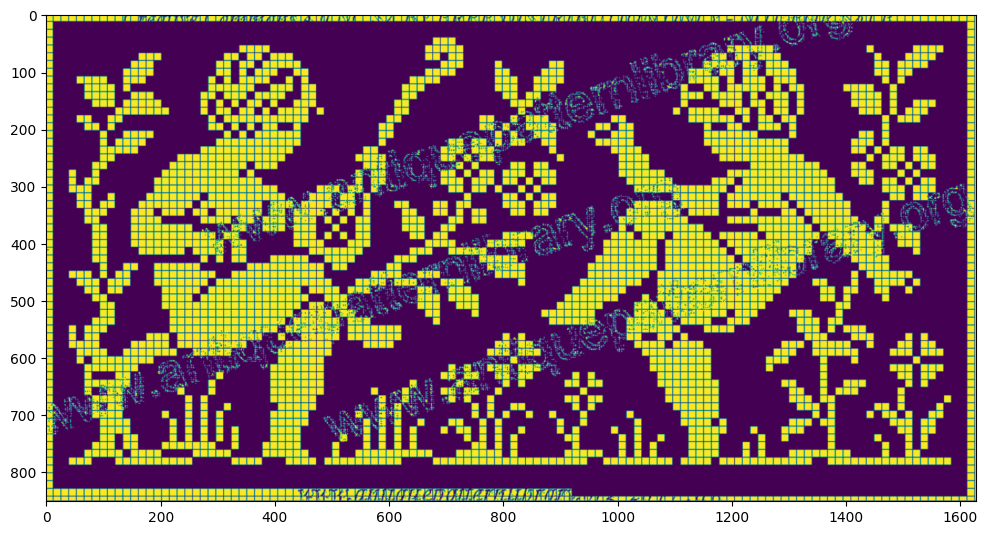

In [4]:
fig = plt.figure(figsize=(12,12))
print("Original image")
plt.imshow(im)
im.type

In [34]:
def conv2d(t,f):
    """Perform convolution on monochrome image 2d-tensor `t` with kernel/filter `f`. Stride=1. Padding=0.
    t is of shape (h,w), where
    h - height
    w - width
    f is of shape (f_sz,f_sz)
    """
    assert t.dim() == 2, "Expecting a 2d tensor (monochrome image)"
    h,w = t.shape
    f_sz = f.shape[0]
    out = torch.zeros((h-f_sz+1,w-f_sz+1))

    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = (t[i:i+f_sz,j:j+f_sz] * f).sum()

    return out

Sobel operator

In [33]:
torch.set_printoptions(precision=3)

#vertical
svf = torch.tensor([[-1.,0.,1.],[-2.,0.,2.],[-1.,0.,1.]])/8
print('Vertical',svf)
#horizontal
shf = svf.t()
print('Horizontal',shf)

Vertical tensor([[-0.125,  0.000,  0.125],
        [-0.250,  0.000,  0.250],
        [-0.125,  0.000,  0.125]])
Horizontal tensor([[-0.125, -0.250, -0.125],
        [ 0.000,  0.000,  0.000],
        [ 0.125,  0.250,  0.125]])


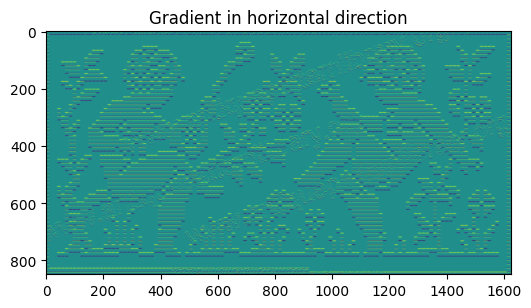

In [38]:
grad_x = conv2d(im,shf)
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(grad_x);
ax.set_title("Gradient in horizontal direction");

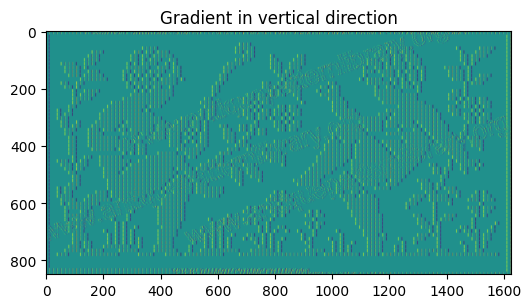

In [37]:
grad_y = conv2d(im,svf)
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(grad_y);
ax.set_title("Gradient in vertical direction");

Magnitude

Text(0.5, 1.0, 'Magnitude of gradients')

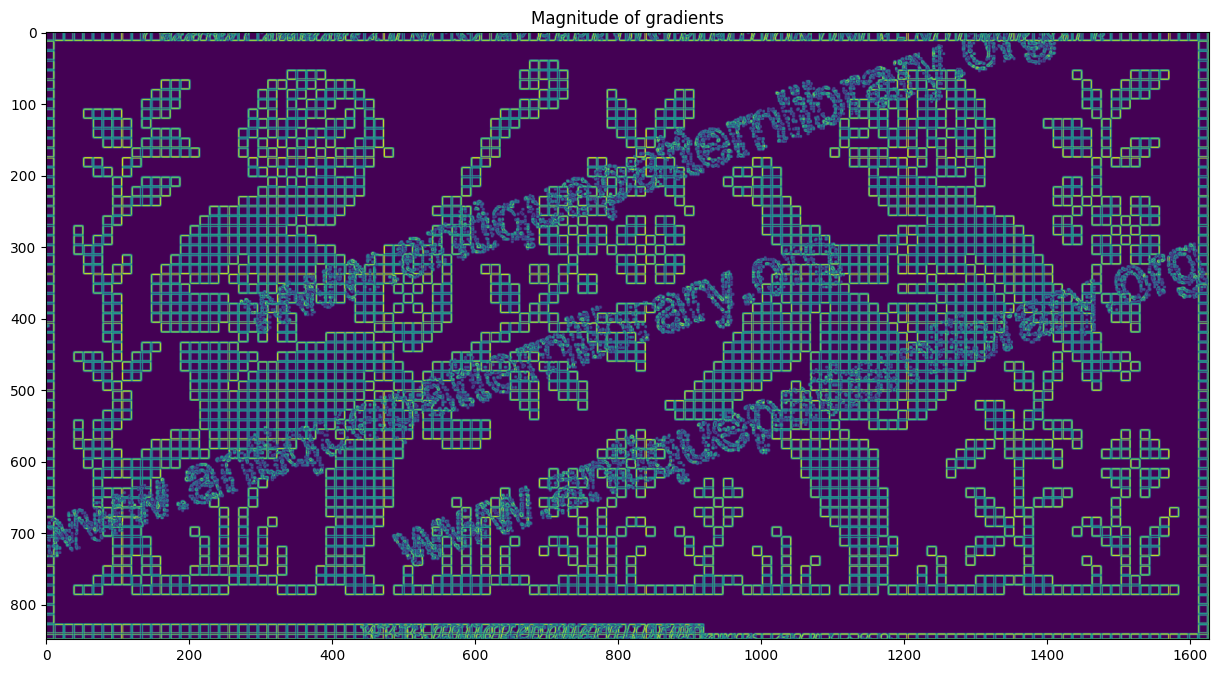

In [52]:
res = ((grad_x*grad_x) + (grad_y*grad_y)).sqrt()
plt.rcParams['image.cmap'] = 'viridis' 
fig, ax = plt.subplots(1,1, figsize = (15,15))
# res[res < 0.0004] = 0
ax.imshow(res)
ax.set_title('Magnitude of gradients')


3D Plotting

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
def f(row, col):
    return res[row,col]
rows = np.arange(0, res.shape[0])
cols = np.arange(0, res.shape[1])

X, Y = np.meshgrid(rows, cols)
Z = f(X, Y)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 150, cmap='viridis')

ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_zlabel('z');
ax.view_init(60, -30)

In [85]:
res.min()

tensor(2.910e-11)

Hough Line Transormation - From Torch to CV2

torch.FloatTensor
<class 'numpy.ndarray'>


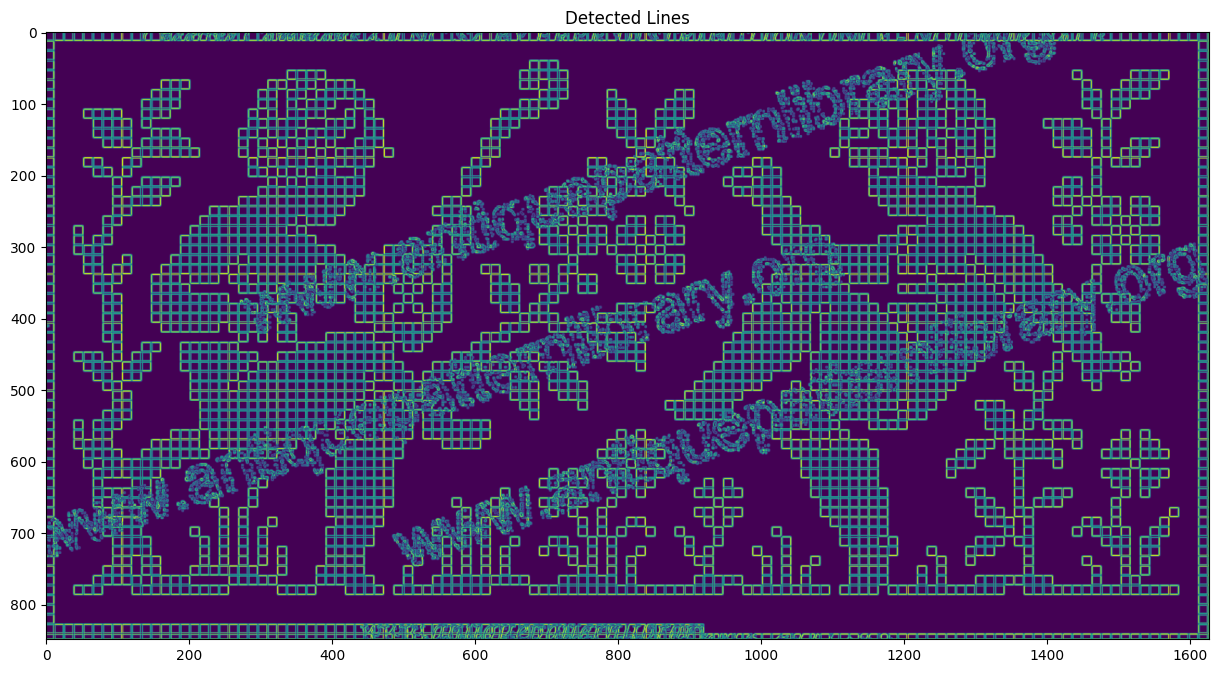

In [127]:
res_normalized = res / res.max()
edges = (res_normalized.numpy() * 255).astype(np.uint8)
# Show result
fig, ax = plt.subplots(1,1,figsize=(15, 15))
ax.imshow(edges)
ax.set_title("Detected Lines")

# Origninal image from tensor to np.array for cv2 
im_cv2 = (im.numpy() * 255).astype(np.uint8)

In [128]:
values , count  = np.unique(edges, return_counts= True)
here = dict(zip(values, count))


Text(0.5, 1.0, 'Detected Lines')

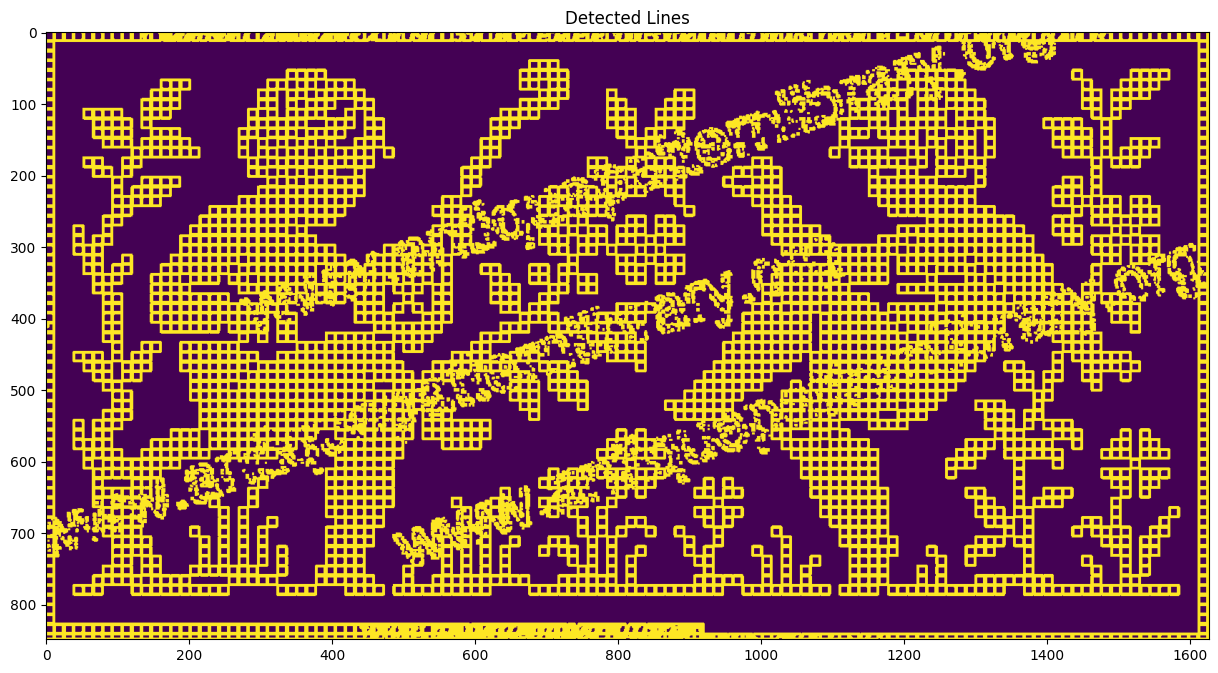

In [129]:
_, binary_edges = cv2.threshold(edges, 100, 255, cv2.THRESH_BINARY)

# Optionally: dilate to fill gaps in lines
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(binary_edges, kernel, iterations=1)

fig, ax = plt.subplots(1,1,figsize=(15, 15))
ax.imshow(dilated)
ax.set_title("Detected Lines")


Text(0.5, 1.0, 'Hope')

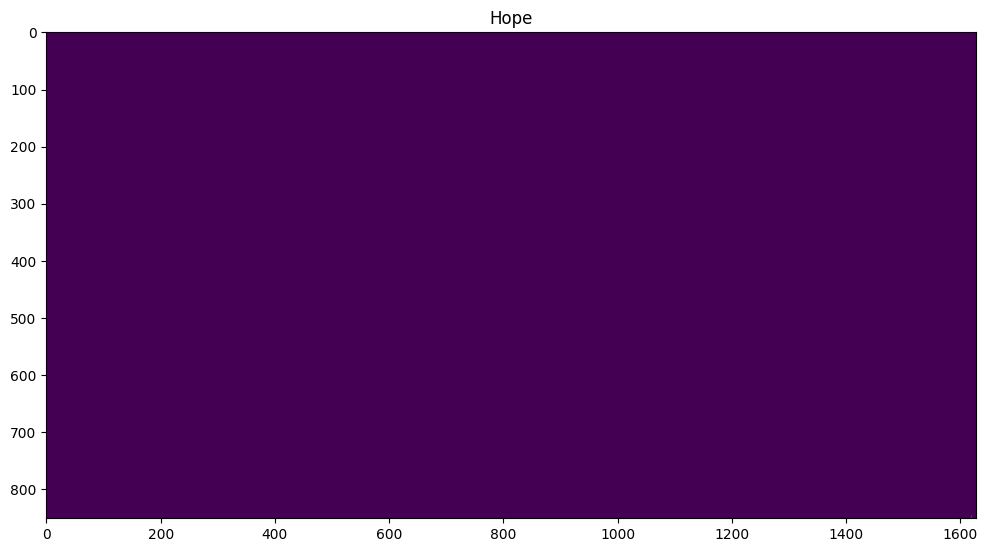

: 

In [ ]:
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=0)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(im_cv2, (x1,y1), (x2,y2), (0,0,255), 2)

fig, ax = plt.subplots(1,1, figsize =(12, 12))
plt.imshow(im_cv2)
plt.title("Hope")
